# Quantative analysis of Price changes of Apple Stock 2015-2020

- Are daily prices change normally distributed?¶
- Are daily prices change significantly from zero?
- Are price changes can be described as random walks?

## 1.Set up an environment and read the data

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import norm

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()['color']
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_csv('AAPL.csv', delimiter = ',',encoding='latin-1')
df

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.04,132.26,130.05,130.34,45833246,121.68,121.88,119.84,120.11,45833246,0.00,1.00
1,1,AAPL,2015-05-28 00:00:00+00:00,131.78,131.95,131.10,131.86,30733309,121.44,121.60,120.81,121.51,30733309,0.00,1.00
2,2,AAPL,2015-05-29 00:00:00+00:00,130.28,131.45,129.90,131.23,50884452,120.06,121.13,119.71,120.93,50884452,0.00,1.00
3,3,AAPL,2015-06-01 00:00:00+00:00,130.53,131.39,130.05,131.20,32112797,120.29,121.08,119.84,120.90,32112797,0.00,1.00
4,4,AAPL,2015-06-02 00:00:00+00:00,129.96,130.66,129.32,129.86,33667627,119.76,120.40,119.17,119.67,33667627,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.32,313.17,33843125,314.96,316.50,310.32,313.17,33843125,0.00,1.00
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.01,315.03,25432385,313.14,318.52,313.01,315.03,25432385,0.00,1.00
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.20,316.68,27876215,319.23,319.52,316.20,316.68,27876215,0.00,1.00
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.87,318.66,25672211,316.85,320.89,315.87,318.66,25672211,0.00,1.00


## 2. Cleaning the dataset

In [141]:
df.isnull().sum()

Unnamed: 0     0
symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [142]:
df.dtypes

Unnamed: 0       int64
symbol          object
date            object
close          float64
high           float64
low            float64
open           float64
volume           int64
adjClose       float64
adjHigh        float64
adjLow         float64
adjOpen        float64
adjVolume        int64
divCash        float64
splitFactor    float64
dtype: object

In [143]:
df['date'] = pd.to_datetime(df['date'], utc=True)

df['date'] = df['date'].dt.date

df.set_index('date', inplace = True)

df

,Unnamed: 0,symbol,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,,,
2015-05-27,0,AAPL,132.04,132.26,130.05,130.34,45833246,121.68,121.88,119.84,120.11,45833246,0.00,1.00
2015-05-28,1,AAPL,131.78,131.95,131.10,131.86,30733309,121.44,121.60,120.81,121.51,30733309,0.00,1.00
2015-05-29,2,AAPL,130.28,131.45,129.90,131.23,50884452,120.06,121.13,119.71,120.93,50884452,0.00,1.00
2015-06-01,3,AAPL,130.53,131.39,130.05,131.20,32112797,120.29,121.08,119.84,120.90,32112797,0.00,1.00
2015-06-02,4,AAPL,129.96,130.66,129.32,129.86,33667627,119.76,120.40,119.17,119.67,33667627,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,1253,AAPL,314.96,316.50,310.32,313.17,33843125,314.96,316.50,310.32,313.17,33843125,0.00,1.00
2020-05-19,1254,AAPL,313.14,318.52,313.01,315.03,25432385,313.14,318.52,313.01,315.03,25432385,0.00,1.00
2020-05-20,1255,AAPL,319.23,319.52,316.20,316.68,27876215,319.23,319.52,316.20,316.68,27876215,0.00,1.00


## 3. Store rate of retunr(daily price change) in a series

In [144]:
# I want to make quantitve stock price analysis of the Stock prices of Apple from 2015 to 2020
apple_return = round(np.log(df['close']).diff() * 100,2)

apple_return

date
2015-05-27     NaN
2015-05-28   -0.20
2015-05-29   -1.14
2015-06-01    0.20
2015-06-02   -0.44
              ... 
2020-05-18    2.33
2020-05-19   -0.58
2020-05-20    1.93
2020-05-21   -0.75
2020-05-22    0.64
Name: close, Length: 1258, dtype: float64

<Axes: xlabel='date'>

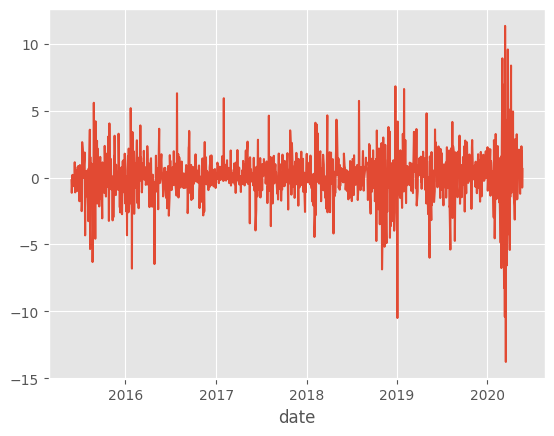

In [145]:
apple_return.plot()

## 4.Use scipy in order to get the descriptive statistics for rate of return series

In [146]:
stats.describe(apple_return)

DescribeResult(nobs=1258, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

In [147]:
apple_return.dropna(inplace = True)
n, minmax, mean, var, skew, kurt = stats.describe(apple_return)
mini, maxi= minmax
std = var**.5


(array([  1.,   1.,   1.,   1.,   8.,  18.,  78., 312., 613., 175.,  33.,
          9.,   3.,   3.,   1.]),
 array([-13.77      , -12.09733333, -10.42466667,  -8.752     ,
         -7.07933333,  -5.40666667,  -3.734     ,  -2.06133333,
         -0.38866667,   1.284     ,   2.95666667,   4.62933333,
          6.302     ,   7.97466667,   9.64733333,  11.32      ]),
 <BarContainer object of 15 artists>)

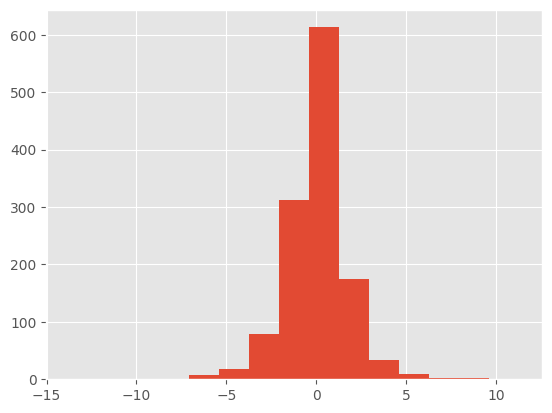

In [148]:
plt.hist(apple_return,bins = 15)

## In order to test the normal distribution hypothesis for rate of return, we need to generate randon numbers that follow normal distribution

In [149]:
x = norm.rvs(mean,std,n)

(array([  4.,  10.,  15.,  43.,  80., 162., 188., 212., 228., 154.,  79.,
         49.,  20.,  10.,   3.]),
 array([-5.90207244, -5.10146972, -4.30086701, -3.5002643 , -2.69966158,
        -1.89905887, -1.09845616, -0.29785344,  0.50274927,  1.30335199,
         2.1039547 ,  2.90455741,  3.70516013,  4.50576284,  5.30636555,
         6.10696827]),
 <BarContainer object of 15 artists>)

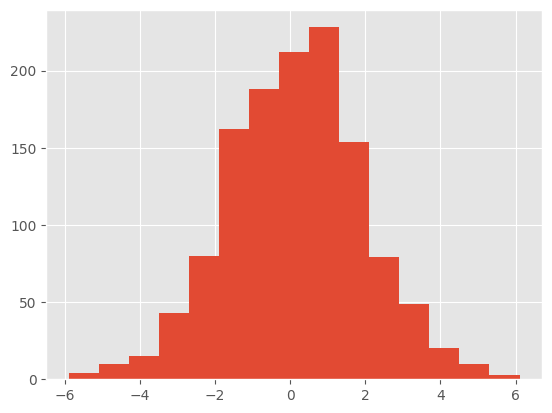

In [150]:
plt.hist(x,bins = 15)

# Is rate of return normally distributed?

##  In order to check that, we will need to test the kurtosis with scipy. The null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [151]:
x_test = stats.kurtosistest(x)
apple_test = stats.kurtosistest(apple_return)
# we always assume alpha = 0.5
print(f'{"Test statistic":20}{"P-value":15}')
print(f'{"-"*5}{"-"*30}')
print(f'x:{x_test[0]:>17.2f}{x_test[1]:16.4f}')
print(f'Apple:{apple_test[0]:13.2f}{apple_test[1]:16.4f}')




Test statistic      P-value        
-----------------------------------
x:             1.47          0.1406
Apple:        14.29          0.0000


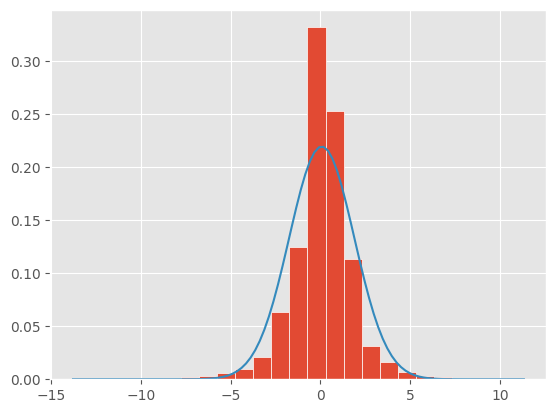

In [152]:
plt.hist(apple_return,bins =25,edgecolor = "w",density=True)
overlay = np.linspace(mini,maxi,100)
plt.plot(overlay,norm.pdf(overlay,mean,std))

## Answer:Reject the null for Apple and we cant say that price change of the stocks is normally distributed.

# Is price changes significantly different from zero?


In [153]:
stats.ttest_1samp(apple_return.sample(252),0,alternative = 'two-sided')

# we always assume alpha = 0.5
# i am not rejecting the null

TtestResult(statistic=2.150307341352453, pvalue=0.03248637965522939, df=251)

# Is price changes are random walks?


In [154]:
apple_close = pd.DataFrame(df['close'])
apple_close['lag1'] = apple_close.close.shift(1)
apple_close['lag2'] = apple_close.close.shift(2)
apple_close.dropna(inplace = True)
apple_close


,close,lag1,lag2
date,,,
2015-05-29,130.28,131.78,132.04
2015-06-01,130.53,130.28,131.78
2015-06-02,129.96,130.53,130.28
2015-06-03,130.12,129.96,130.53
2015-06-04,129.36,130.12,129.96
...,...,...,...
2020-05-18,314.96,307.71,309.54
2020-05-19,313.14,314.96,307.71
2020-05-20,319.23,313.14,314.96


In [164]:
lr = np.linalg.lstsq(apple_close[['lag1','lag2']],apple_close['close'],rcond = None)[0]
lr

array([0.80121849, 0.19989232])

In [165]:
apple_close['predict'] = np.dot(apple_close[['lag1','lag2']], lr)
apple_close

,close,lag1,lag2,predict
date,,,,
2015-05-29,130.28,131.78,132.04,131.98
2015-06-01,130.53,130.28,131.78,130.72
2015-06-02,129.96,130.53,130.28,130.63
2015-06-03,130.12,129.96,130.53,130.22
2015-06-04,129.36,130.12,129.96,130.23
...,...,...,...,...
2020-05-18,314.96,307.71,309.54,308.42
2020-05-19,313.14,314.96,307.71,313.86
2020-05-20,319.23,313.14,314.96,313.85


In [166]:
apple_close

,close,lag1,lag2,predict
date,,,,
2015-05-29,130.28,131.78,132.04,131.98
2015-06-01,130.53,130.28,131.78,130.72
2015-06-02,129.96,130.53,130.28,130.63
2015-06-03,130.12,129.96,130.53,130.22
2015-06-04,129.36,130.12,129.96,130.23
...,...,...,...,...
2020-05-18,314.96,307.71,309.54,308.42
2020-05-19,313.14,314.96,307.71,313.86
2020-05-20,319.23,313.14,314.96,313.85


<Axes: xlabel='date'>

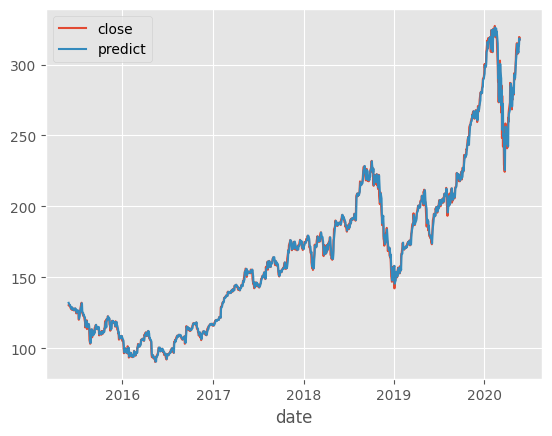

In [167]:
apple_close[['close','predict']].plot()

## As we see on the plot, we are able to forecast tomorrow's price with today's price, so we can assume that they are not random walks.